# Batch Normalization – Lesson

1. [What is it?](#theory)
2. [What are it's benefits?](#benefits)
3. [How do we add it to a network?](#implementation_1)
4. [Let's see it work!](#demos)
5. [What are you hiding?](#implementation_2)

# What is Batch Normalization?<a id='theory'></a>

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. It's called "batch" normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current mini-batch.

Why might this help? Well, we know that normalizing the inputs to a _network_ helps the network learn. But a network is a series of layers, where the output of one layer becomes the input to another. That means we can think of any layer in a neural network as the _first_ layer of a smaller network.

For example, imagine a 3 layer network. Instead of just thinking of it as a single network with inputs, layers, and outputs, think of the output of layer 1 as the input to a two layer network. This two layer network would consist of layers 2 and 3 in our original network. 

Likewise, the output of layer 2 can be thought of as the input to a single layer network, consistng only of layer 3.

When you think of it like that - as a series of neural networks feeding into each other - then it's easy to imagine how normalizing the inputs to each layer would help. It's just like normalizing the inputs to any other neural network, but you're doing it at every layer (sub-network).

Beyond the intuitive reasons, there are good mathematical reasons why it helps the network learn better, too. It helps combat what the authors call _internal covariate shift_. This discussion is best handled [in the paper](https://arxiv.org/pdf/1502.03167.pdf) and in [Deep Learning](http://www.deeplearningbook.org) a book you can read online written by Ian Goodfellow, Yoshua Bengio, and Aaron Courville. Specifically, check out the batch normalization section of [Chapter 8: Optimization for Training Deep Models](http://www.deeplearningbook.org/contents/optimization.html).

# Benefits of Batch Normalization<a id="benefits"></a>

Batch normalization optimizes network training. It has been shown to have several benefits:
1. **Networks train faster** – Each training _iteration_ will actually be slower because of the extra calculations during the forward pass and the additional hyperparameters to train during back propagation. However, it should converge much more quickly, so training should be faster overall. 
2. **Allows higher learning rates** – Gradient descent usually requires small learning rates for the network to converge. And as networks get deeper, their gradients get smaller during back propagation so they require even more iterations. Using batch normalization allows us to use much higher learning rates, which further increases the speed at which networks train. 
3. **Makes weights easier to initialize** – Weight initialization can be difficult, and it's even more difficult when creating deeper networks. Batch normalization seems to allow us to be much less careful about choosing our initial starting weights.  
4. **Makes more activation functions viable** – Some activation functions do not work well in some situations. Sigmoids lose their gradient pretty quickly, which means they can't be used in deep networks. And ReLUs often die out during training, where they stop learning completely, so we need to be careful about the range of values fed into them. Because batch normalization regulates the values going into each activation function, non-linearlities that don't seem to work well in deep networks actually become viable again.  
5. **Simplifies the creation of deeper networks** – Because of the first 4 items listed above, it is easier to build and faster to train deeper neural networks when using batch normalization. And it's been shown that deeper networks generally produce better results, so that's great.
6. **Provides a bit of regularlization** – Batch normalization adds a little noise to your network. In some cases, such as in Inception modules, batch normalization has been shown to work as well as dropout. But in general, consider batch normalization as a bit of extra regularization, possibly allowing you to reduce some of the dropout you might add to a network. 
7. **May give better results overall** – Some tests seem to show batch normalization actually improves the train.ing results. However, it's really an optimization to help train faster, so you shouldn't think of it as a way to make your network better. But since it lets you train networks faster, that means you can iterate over more designs more quickly. It also lets you build deeper networks, which are usually better. So when you factor in everything, you're probably going to end up with better results if you build your networks with batch normalization.

# Batch Normalization in TensorFlow<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in TensorFlow. 

The following cell imports the packages we need in the notebook and loads the MNIST dataset to use in our experiments. However, the `tensorflow` package contains all the code you'll actually need for batch normalization.

In [1]:
%%time
# Import necessary packages
import tensorflow as tf
import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import MNIST data so we have something for our experiments
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
CPU times: user 14.7 s, sys: 864 ms, total: 15.6 s
Wall time: 16 s


### Neural network classes for testing

下一个类`NeuralNet`允许我们在批处理规范化和不批处理规范化的情况下创建相同的神经网络。这段代码有大量的文档记录，但后面还有一些额外的讨论。在浏览笔记本的其余部分之前，您不需要通读所有内容，但是代码块中的注释可能会回答您的一些问题。     
        
*关于代码：*       
>这个类并不代表TensorFlow的最佳实践——这里所做的设计选择是为了支持与批处理规范化相关的讨论。        
>值得注意的是，我们在这些例子中使用了著名的MNIST数据，但是我们创建的网络并不适合执行手写字符识别。我们之所以选择这种网络架构，是因为它**类似于原始论文中使用的网络架构**，其复杂程度<u>足以证明批处理规范化</u>的一些好处，同时仍然可以<u>快速进行训练</u>。      

In [2]:
class NeuralNet:
    def __init__(self, initial_weights, activation_fn, use_batch_norm):
        """
        Initializes this object, creating a TensorFlow graph using the given parameters.
        
        :param initial_weights: list of NumPy arrays or Tensors
            Initial values for the weights for every layer in the network. We pass these in
            so we can create multiple networks with the same starting weights to eliminate
            training differences caused by random initialization differences.
            The number of items in the list defines the number of layers in the network,
            and the shapes of the items in the list define the number of nodes in each layer.
            e.g. Passing in 3 matrices of shape (784, 256), (256, 100), and (100, 10) would 
            create a network with 784 inputs going into a hidden layer with 256 nodes,
            followed by a hidden layer with 100 nodes, followed by an output layer with 10 nodes.
        :param activation_fn: Callable
            The function used for the output of each hidden layer. The network will use the same
            activation function on every hidden layer and no activate function on the output layer.
            e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
        :param use_batch_norm: bool
            Pass True to create a network that uses batch normalization; False otherwise
            Note: this network will not use batch normalization on layers that do not have an
            activation function.
        """
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        self.name = "With Batch Norm" if use_batch_norm else "Without Batch Norm"

        # Batch normalization needs to do different calculations during training and inference,
        # so we use this placeholder to tell the graph which behavior to use.
        self.is_training = tf.placeholder(tf.bool, name="is_training")

        # This list is just for keeping track of data we want to plot later.
        # It doesn't actually have anything to do with neural nets or batch normalization.
        self.training_accuracies = []

        # Create the network graph, but it will not actually have any real values until after you
        # call train or test
        self.build_network(initial_weights, activation_fn)
    
    def build_network(self, initial_weights, activation_fn):
        """
        Build the graph. The graph still needs to be trained via the `train` method.
        
        :param initial_weights: list of NumPy arrays or Tensors
            See __init__ for description. 
        :param activation_fn: Callable
            See __init__ for description. 
        """
        self.input_layer = tf.placeholder(tf.float32, [None, initial_weights[0].shape[0]])
        layer_in = self.input_layer
        for weights in initial_weights[:-1]:
            layer_in = self.fully_connected(layer_in, weights, activation_fn)    
        self.output_layer = self.fully_connected(layer_in, initial_weights[-1])
   
    def fully_connected(self, layer_in, initial_weights, activation_fn=None):
        """
        Creates a standard, fully connected layer. Its number of inputs and outputs will be
        defined by the shape of `initial_weights`, and its starting weight values will be
        taken directly from that same parameter. If `self.use_batch_norm` is True, this
        layer will include batch normalization, otherwise it will not. 
        
        :param layer_in: Tensor
            The Tensor that feeds into this layer. It's either the input to the network or the output
            of a previous layer.
        :param initial_weights: NumPy array or Tensor
            Initial values for this layer's weights. The shape defines the number of nodes in the layer.
            e.g. Passing in 3 matrix of shape (784, 256) would create a layer with 784 inputs and 256 
            outputs. 
        :param activation_fn: Callable or None (default None)
            The non-linearity used for the output of the layer. If None, this layer will not include 
            batch normalization, regardless of the value of `self.use_batch_norm`. 
            e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
        """
        # Since this class supports both options, only use batch normalization when
        # requested. However, do not use it on the final layer, which we identify
        # by its lack of an activation function.
        if self.use_batch_norm and activation_fn:
            # Batch normalization uses weights as usual, but does NOT add a bias term. This is because 
            # its calculations include gamma and beta variables that make the bias term unnecessary.
            # (See later in the notebook for more details.)
            weights = tf.Variable(initial_weights)
            linear_output = tf.matmul(layer_in, weights)

            # Apply batch normalization to the linear combination of the inputs and weights
            batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)

            # Now apply the activation function, *after* the normalization.
            return activation_fn(batch_normalized_output)
        else:
            # When not using batch normalization, create a standard layer that multiplies
            # the inputs and weights, adds a bias, and optionally passes the result 
            # through an activation function.  
            weights = tf.Variable(initial_weights)
            biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
            linear_output = tf.add(tf.matmul(layer_in, weights), biases)
            return linear_output if not activation_fn else activation_fn(linear_output)

    def train(self, session, learning_rate, training_batches, batches_per_sample, save_model_as=None):
        """
        Trains the model on the MNIST training dataset.
        
        :param session: Session
            Used to run training graph operations.
        :param learning_rate: float
            Learning rate used during gradient descent.
        :param training_batches: int
            Number of batches to train.
        :param batches_per_sample: int
            How many batches to train before sampling the validation accuracy.
        :param save_model_as: string or None (default None)
            Name to use if you want to save the trained model.
        """
        # This placeholder will store the target labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, 10])

        # Define loss and optimizer
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=self.output_layer))
        
        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        if self.use_batch_norm:
            # If we don't include the update ops as dependencies on the train step, the 
            # tf.layers.batch_normalization layers won't update their population statistics,
            # which will cause the model to fail at inference time
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        else:
            train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
        # Train for the appropriate number of batches. (tqdm is only for a nice timing display)
        for i in tqdm.tqdm(range(training_batches)):
            # We use batches of 60 just because the original paper did. You can use any size batch you like.
            batch_xs, batch_ys = mnist.train.next_batch(60)
            session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                               labels: batch_ys, 
                                               self.is_training: True})
        
            # Periodically test accuracy against the 5k validation images and store it for plotting later.
            if i % batches_per_sample == 0:
                test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                                 labels: mnist.validation.labels,
                                                                 self.is_training: False})
                self.training_accuracies.append(test_accuracy)

        # After training, report accuracy against test data
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.validation.images,
                                                         labels: mnist.validation.labels,
                                                         self.is_training: False})
        print('{}: After training, final accuracy on validation set = {}'.format(self.name, test_accuracy))

        # If you want to use this model later for inference instead of having to retrain it,
        # just construct it with the same parameters and then pass this file to the 'test' function
        if save_model_as:
            tf.train.Saver().save(session, save_model_as)

    def test(self, session, test_training_accuracy=False, include_individual_predictions=False, restore_from=None):
        """
        Trains a trained model on the MNIST testing dataset.

        :param session: Session
            Used to run the testing graph operations.
        :param test_training_accuracy: bool (default False)
            If True, perform inference with batch normalization using batch mean and variance;
            if False, perform inference with batch normalization using estimated population mean and variance.
            Note: in real life, *always* perform inference using the population mean and variance.
                  This parameter exists just to support demonstrating what happens if you don't.
        :param include_individual_predictions: bool (default True)
            This function always performs an accuracy test against the entire test set. But if this parameter
            is True, it performs an extra test, doing 200 predictions one at a time, and displays the results
            and accuracy.
        :param restore_from: string or None (default None)
            Name of a saved model if you want to test with previously saved weights.
        """
        # This placeholder will store the true labels for each mini batch
        labels = tf.placeholder(tf.float32, [None, 10])

        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # If provided, restore from a previously saved model
        if restore_from:
            tf.train.Saver().restore(session, restore_from)

        # Test against all of the MNIST test data
        test_accuracy = session.run(accuracy, feed_dict={self.input_layer: mnist.test.images,
                                                         labels: mnist.test.labels,
                                                         self.is_training: test_training_accuracy})
        print('-'*75)
        print('{}: Accuracy on full test set = {}'.format(self.name, test_accuracy))

        # If requested, perform tests predicting individual values rather than batches
        if include_individual_predictions:
            predictions = []
            correct = 0

            # Do 200 predictions, 1 at a time
            for i in range(200):
                # This is a normal prediction using an individual test case. However, notice
                # we pass `test_training_accuracy` to `feed_dict` as the value for `self.is_training`.
                # Remember that will tell it whether it should use the batch mean & variance or
                # the population estimates that were calucated while training the model.
                pred, corr = session.run([tf.arg_max(self.output_layer,1), accuracy],
                                         feed_dict={self.input_layer: [mnist.test.images[i]],
                                                    labels: [mnist.test.labels[i]],
                                                    self.is_training: test_training_accuracy})
                correct += corr

                predictions.append(pred[0])

            print("200 Predictions:", predictions)
            print("Accuracy on 200 samples:", correct/200)


There are quite a few comments in the code, so those should answer most of your questions. However, let's take a look at the most important lines.

We add batch normalization to layers inside the `fully_connected` function. Here are some important points about that code:
1. Layers with batch normalization do not include a bias term.
2. We use TensorFlow's [`tf.layers.batch_normalization`](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization) function to handle the math. (We show lower-level ways to do this [later in the notebook](#implementation_2).)
3. We tell `tf.layers.batch_normalization` whether or not the network is training. This is an important step we'll talk about later.
4. We add the normalization **before** calling the activation function.

In addition to that code, the training step is wrapped in the following `with` statement:
```python
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
```
This line actually works in conjunction with the `training` parameter we pass to `tf.layers.batch_normalization`. Without it, TensorFlow's batch normalization layer will not operate correctly during inference.

Finally, whenever we train the network or perform inference, we use the `feed_dict` to set `self.is_training` to `True` or `False`, respectively, like in the following line:
```python
session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                               labels: batch_ys, 
                                               self.is_training: True})
```
We'll go into more details later, but next we want to show some experiments that use this code and test networks with and without batch normalization.

# Batch Normalization Demos<a id='demos'></a>
This section of the notebook trains various networks with and without batch normalization to demonstrate some of the benefits mentioned earlier. 

We'd like to thank the author of this blog post [Implementing Batch Normalization in TensorFlow](http://r2rt.com/implementing-batch-normalization-in-tensorflow.html). That post provided the idea of - and some of the code for - plotting the differences in accuracy during training, along with the idea for comparing multiple networks using the same initial weights.

## Code to support testing

The following two functions support the demos we run in the notebook. 

The first function, `plot_training_accuracies`, simply plots the values found in the `training_accuracies` lists of the `NeuralNet` objects passed to it. If you look at the `train` function in `NeuralNet`, you'll see it that while it's training the network, it periodically measures validation accuracy and stores the results in that list. It does that just to support these plots.

The second function, `train_and_test`, creates two neural nets - one with and one without batch normalization. It then trains them both and tests them, calling `plot_training_accuracies` to plot how their accuracies changed over the course of training. The really imporant thing about this function is that it initializes the starting weights for the networks _outside_ of the networks and then passes them in. This lets it train both networks from the exact same starting weights, which eliminates performance differences that might result from (un)lucky initial weights.

In [3]:
def plot_training_accuracies(*args, **kwargs):
    """
    Displays a plot of the accuracies calculated during training to demonstrate
    how many iterations it took for the model(s) to converge.
    
    :param args: One or more NeuralNet objects
        You can supply any number of NeuralNet objects as unnamed arguments 
        and this will display their training accuracies. Be sure to call `train` 
        the NeuralNets before calling this function.
    :param kwargs: 
        You can supply any named parameters here, but `batches_per_sample` is the only
        one we look for. It should match the `batches_per_sample` value you passed
        to the `train` function.
    """
    fig, ax = plt.subplots()

    batches_per_sample = kwargs['batches_per_sample']
    
    for nn in args:
        ax.plot(range(0,len(nn.training_accuracies)*batches_per_sample,batches_per_sample),
                nn.training_accuracies, label=nn.name)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Validation Accuracy During Training')
    ax.legend(loc=4)
    ax.set_ylim([0,1])
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)activation_fn
    plt.show()

def train_and_test(use_bad_weights, learning_rate, activation_fn, training_batches=50000, batches_per_sample=500):
    """
    Creates two networks, one with and one without batch normalization, then trains them
    with identical starting weights, layers, batches, etc. Finally tests and plots their accuracies.
    
    :param use_bad_weights: bool
        If True, initialize the weights of both networks to wildly inappropriate weights;
        if False, use reasonable starting weights.
    :param learning_rate: float
        Learning rate used during gradient descent.
    :param activation_fn: Callable
        The function used for the output of each hidden layer. The network will use the same
        activation function on every hidden layer and no activate function on the output layer.
        e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
    :param training_batches: (default 50000)
        Number of batches to train.
    :param batches_per_sample: (default 500)
        How many batches to train before sampling the validation accuracy.
    """
    # Use identical starting weights for each network to eliminate differences in
    # weight initialization as a cause for differences seen in training performance
    #
    # Note: The networks will use these weights to define the number of and shapes of
    #       its layers. The original batch normalization paper used 3 hidden layers
    #       with 100 nodes in each, followed by a 10 node output layer. These values
    #       build such a network, but feel free to experiment with different choices.
    #       However, the input size should always be 784 and the final output should be 10.
    if use_bad_weights:
        # These weights should be horrible because they have such a large standard deviation
        weights = [np.random.normal(size=(784,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,100), scale=5.0).astype(np.float32),
                   np.random.normal(size=(100,10), scale=5.0).astype(np.float32)
                  ]
    else:
        # These weights should be good because they have such a small standard deviation
        weights = [np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
                   np.random.normal(size=(100,10), scale=0.05).astype(np.float32)
                  ]

    # Just to make sure the TensorFlow's default graph is empty before we start another
    # test, because we don't bother using different graphs or scoping and naming 
    # elements carefully in this sample code.
    tf.reset_default_graph()

    # build two versions of same network, 1 without and 1 with batch normalization
    nn = NeuralNet(weights, activation_fn, False)
    bn = NeuralNet(weights, activation_fn, True)
    
    # train and test the two models
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        nn.train(sess, learning_rate, training_batches, batches_per_sample)
        bn.train(sess, learning_rate, training_batches, batches_per_sample)
    
        nn.test(sess)
        bn.test(sess)
    
    # Display a graph of how validation accuracies changed during training
    # so we can compare how the models trained and when they converged
    plot_training_accuracies(nn, bn, batches_per_sample=batches_per_sample)


## Comparisons between identical networks, with and without batch normalization

下一系列的单元训练具有各种设置的网络，以显示具有和不具有批处理规范化的差异。它们旨在清楚地演示批处理规范化的效果。稍后我们将在笔记本中深入讨论批处理规范化。

**下面使用ReLU激活函数创建两个网络，学习率为0.01，初始权重合理**

100%|██████████| 50000/50000 [03:16<00:00, 255.07it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9760000109672546


100%|██████████| 50000/50000 [05:07<00:00, 162.45it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9797999858856201
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9750999808311462
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9779000282287598


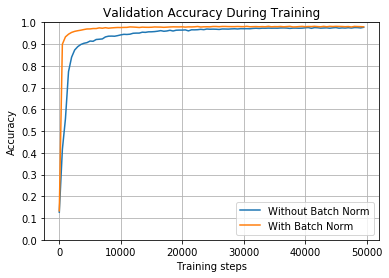

CPU times: user 7min 52s, sys: 16.5 s, total: 8min 8s
Wall time: 8min 25s


In [4]:
%%time
train_and_test(False, 0.01, tf.nn.relu)

正如预期的那样，两个网络都经过了良好的训练，最终达到了相似的测试精度。但是，请注意，与其他网络相比，具有批处理规范化的模型收敛速度稍快，几乎立即达到90%以上的精度，并在10000或15000次迭代中接近其最大精度。另一个网络需要3000次迭代才能达到90%，直到30000次或更多的迭代才接近其最佳精度。        
           
如果你看一下原始速度，你可以看到，如果没有批处理规范化，我们每秒计算的批数超过1100个，而批处理规范化则下降到500多个。然而，批处理规范化允许我们执行更少的迭代并在更短的时间内收敛。（我们在这里只训练了5万批，所以我们可以绘制比较图。）

**下面创建的两个网络的超参数与前一个示例中使用的相同，但只训练2000次迭代**

100%|██████████| 2000/2000 [00:10<00:00, 199.88it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.854200005531311


100%|██████████| 2000/2000 [00:17<00:00, 113.04it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9517999887466431
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8499000072479248
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9520000219345093


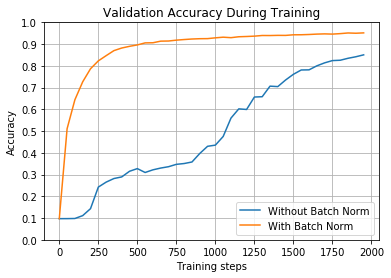

CPU times: user 27.2 s, sys: 921 ms, total: 28.1 s
Wall time: 29.3 s


In [5]:
%%time
train_and_test(False, 0.01, tf.nn.relu, 2000, 50)

如您所见，使用批处理规范化只在2000个批处理中产生了95%以上的准确率的模型，在大约500个批处理中，准确率高于90%。如果没有批处理规范化，该模型需要1750次迭代才能达到80%——具有批处理规范化的网络在大约200次迭代后达到该标记！（注意：如果您自己运行代码，每次都会看到稍微不同的结果，因为每次运行的起始权重（虽然每个模型的起始权重相同）是不同的。）      
                
在上面的例子中，您还应该注意到网络每秒训练的批数比您在前面的例子中看到的要少。这是因为我们跟踪的大部分时间实际上是周期性地进行推断，以收集绘图数据。在本例中，我们每50个批次而不是每500个批次执行一次推断，因此为本例生成绘图需要10倍于相同2000次迭代的开销。

**下面使用一个Sigmoid激活函数创建两个网络，学习率为0.01，起始权重合理**

100%|██████████| 50000/50000 [03:07<00:00, 266.33it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8271999955177307


100%|██████████| 50000/50000 [05:33<00:00, 150.14it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9711999893188477
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8172000050544739
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9713000059127808


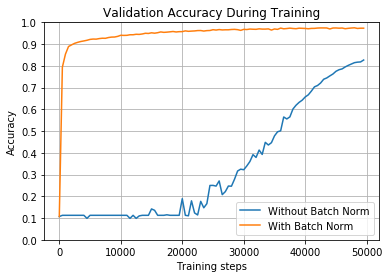

CPU times: user 8min 7s, sys: 16.6 s, total: 8min 23s
Wall time: 8min 42s


In [6]:
%%time
train_and_test(False, 0.01, tf.nn.sigmoid)

由于我们使用的层数和这个小的学习率，使用Sigmoid功能需要很长时间才能开始学习。它最终开始取得进展，但它花了4万5千多批次，才获得超过80%的准确率。使用批处理规范化可以在大约1000个批中达到90%。

**下面使用ReLU激活函数创建两个网络，学习率为1，起始权重合理**

100%|██████████| 50000/50000 [03:12<00:00, 259.67it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [05:24<00:00, 154.18it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9833999872207642
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9828000068664551


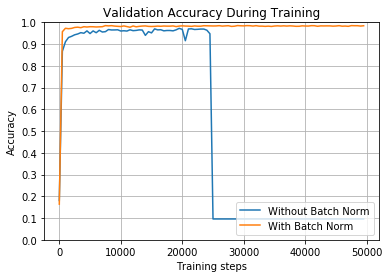

CPU times: user 8min 6s, sys: 16.5 s, total: 8min 22s
Wall time: 8min 38s


In [7]:
%%time
train_and_test(False, 1, tf.nn.relu)

现在我们又在使用ReLUs，但学习率更高。图中显示了训练是如何正常开始的，具有批处理规范化的网络开始得比其他网络快。但是，较高的学习率会使精度反弹更多一点，在某些情况下，没有批处理规范化的网络精度完全崩溃。很可能有太多的雷卢斯死在这一点上，因为高学习率。

下一个单元格再次显示相同的测试。具有批量正则化的网络以同样的方式执行，而另一个网络再次遇到同样的问题，但它设法在发生之前训练更长的时间。

100%|██████████| 50000/50000 [03:05<00:00, 269.59it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [05:07<00:00, 162.76it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9855999946594238
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.984000027179718


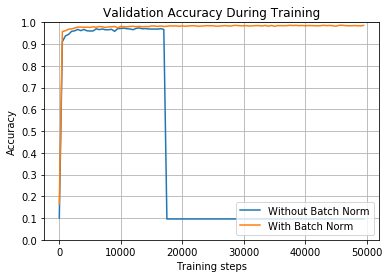

CPU times: user 7min 45s, sys: 16 s, total: 8min 1s
Wall time: 8min 14s


In [8]:
%%time
train_and_test(False, 1, tf.nn.relu)

在前面的两个例子中，具有批量正则化的网络能够获得超过98%的准确率，并且几乎立即接近这个结果。较高的学习率使网络训练速度极快。

**下面使用一个Sigmoid激活函数创建两个网络，学习率为1，并使用合理的起始权重**

100%|██████████| 50000/50000 [03:01<00:00, 275.10it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.979200005531311


100%|██████████| 50000/50000 [05:06<00:00, 163.10it/s]


With Batch Norm: After training, final accuracy on validation set = 0.982200026512146
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9778000116348267
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9818999767303467


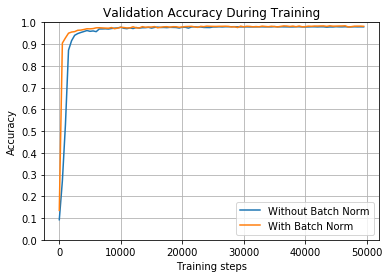

CPU times: user 7min 40s, sys: 16.2 s, total: 7min 57s
Wall time: 8min 10s


In [9]:
%%time
train_and_test(False, 1, tf.nn.sigmoid)

在这个例子中，我们切换到一个Sigmoid激活函数。它似乎很好地处理了较高的学习率，两个网络都达到了较高的精度。    
           
下面的单元格显示了一对只训练了2000次迭代的类似网络。

100%|██████████| 2000/2000 [00:09<00:00, 206.57it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9305999875068665


100%|██████████| 2000/2000 [00:16<00:00, 117.69it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9557999968528748
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9287999868392944
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9534000158309937


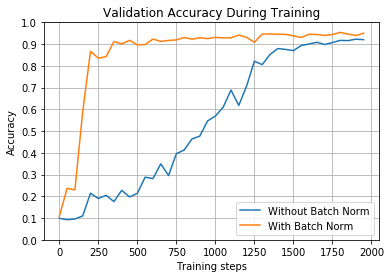

CPU times: user 26.7 s, sys: 990 ms, total: 27.7 s
Wall time: 28.3 s


In [10]:
%%time
train_and_test(False, 1, tf.nn.sigmoid, 2000, 50)

如您所见，尽管这些参数对两个网络都很好，但一个具有批处理规范化的参数在400个左右的批处理中获得了90%以上的结果，而另一个则超过1700个。当训练更大的网络时，这些差异变得更加明显。

**下面使用ReLU激活函数创建两个网络，学习率为2，起始权重合理**

100%|██████████| 50000/50000 [02:58<00:00, 279.51it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [04:56<00:00, 168.41it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9824000000953674
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9829000234603882


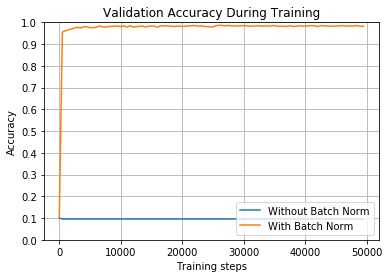

CPU times: user 7min 30s, sys: 15.9 s, total: 7min 46s
Wall time: 7min 57s


In [11]:
%%time 
train_and_test(False, 2, tf.nn.relu)

有了这个非常大的学习率，批量标准化的网络训练得很好，几乎可以立即管理98%的准确率。然而，没有标准化的网络根本无法学习。

**下面使用一个Sigmoid激活函数创建两个网络，学习率为2，起始权重合理**

100%|██████████| 50000/50000 [03:04<00:00, 270.81it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9778000116348267


100%|██████████| 50000/50000 [04:59<00:00, 166.75it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9810000061988831
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9767000079154968
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9789000153541565


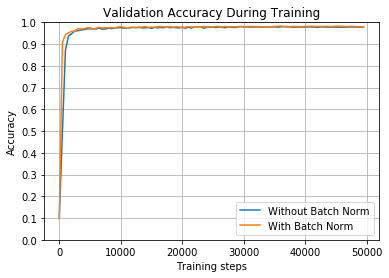

CPU times: user 7min 38s, sys: 16.1 s, total: 7min 54s
Wall time: 8min 6s


In [12]:
%%time
train_and_test(False, 2, tf.nn.sigmoid)

再次，使用具有更大学习率的Sigmoid激活函数，无论是否进行批量规范化，都能很好地工作。       
           
但是，请看下面的图表，我们在其中训练具有相同参数但只有2000次迭代的模型。和往常一样，批处理规范化让它训练得更快。

100%|██████████| 2000/2000 [00:09<00:00, 206.29it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.9585999846458435


100%|██████████| 2000/2000 [00:17<00:00, 116.81it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9557999968528748
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.9498000144958496
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9496999979019165


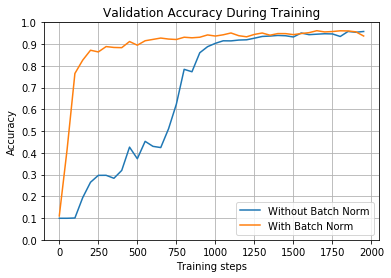

CPU times: user 27.1 s, sys: 874 ms, total: 28 s
Wall time: 28.5 s


In [14]:
%%time
train_and_test(False, 2, tf.nn.sigmoid, 2000, 50)

在其余的例子中，我们使用了非常糟糕的起始重量。也就是说，通常我们会使用非常小的接近于零的值。但是，在这些示例中，我们选择标准偏差为5的随机值。如果你真的在训练一个神经网络，你会**不**想这样做。但这些示例演示了批处理规范化如何使网络更具弹性。

**下面使用ReLU激活函数创建两个网络，学习率为0.01，起始权重不正确**

100%|██████████| 50000/50000 [02:54<00:00, 285.89it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.11259999871253967


100%|██████████| 50000/50000 [04:52<00:00, 170.96it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8230000138282776
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.11349999904632568
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.8242999911308289


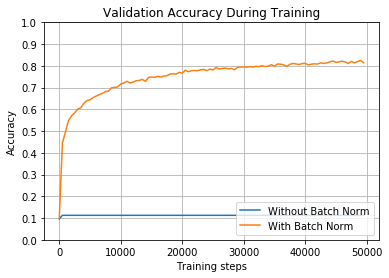

CPU times: user 7min 22s, sys: 15.5 s, total: 7min 37s
Wall time: 7min 48s


In [13]:
%%time
train_and_test(True, 0.01, tf.nn.relu)

如图所示，如果不进行批量规范化，网络将一事无成。但通过批量规范化，它实际上学得很好，准确率接近80%。起始权重显然会损害网络，但是您可以看到批处理规范化在克服它们方面有多好。

**下面使用一个Sigmoid激活函数创建两个网络，学习率为0.01，起始权重不正确**

100%|██████████| 50000/50000 [02:59<00:00, 278.36it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.3188000023365021


100%|██████████| 50000/50000 [04:54<00:00, 169.83it/s]


With Batch Norm: After training, final accuracy on validation set = 0.8641999959945679
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.3160000145435333
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.847000002861023


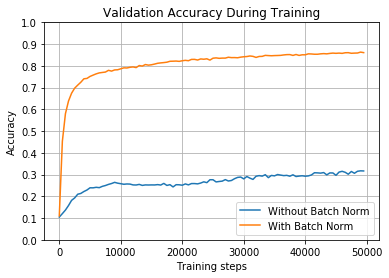

CPU times: user 7min 28s, sys: 15.6 s, total: 7min 44s
Wall time: 7min 55s


In [15]:
%%time
train_and_test(True, 0.01, tf.nn.sigmoid)

使用一个sigmoid激活函数比前一个例子中的ReLU工作得更好，但是如果没有批量规范化，训练网络将需要非常长的时间，如果它曾经训练过的话。

**下面使用ReLU激活函数创建两个网络，学习率为1，并且起始权重不正确**<a id="successful_example_lr_1"></a>

100%|██████████| 50000/50000 [03:00<00:00, 277.52it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [04:58<00:00, 167.37it/s]


With Batch Norm: After training, final accuracy on validation set = 0.847599983215332
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.833299994468689


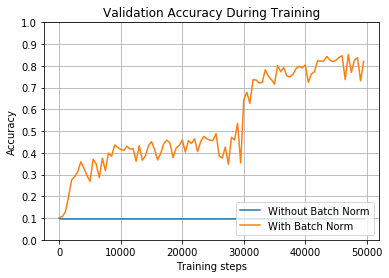

CPU times: user 7min 32s, sys: 16.2 s, total: 7min 49s
Wall time: 8min


In [16]:
%%time
train_and_test(True, 1, tf.nn.relu)

这里使用的更高的学习率允许批量标准化的网络在大约3万个批次中超过90%。没有它的网络永远无法到达任何地方。

**下面使用一个Sigmoid激活函数创建两个网络，学习率为1，并且起始权重不好**

100%|██████████| 50000/50000 [03:06<00:00, 267.41it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8866000175476074


100%|██████████| 50000/50000 [05:20<00:00, 156.07it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9498000144958496
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.8751000165939331
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9484999775886536


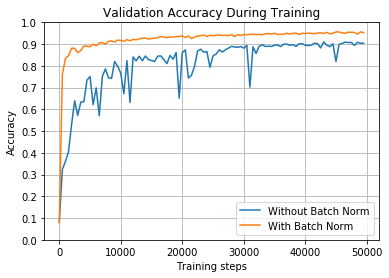

In [17]:
%%time
train_and_test(True, 1, tf.nn.sigmoid)

使用Sigmoid比使用ReLU效果更好，这一较高的学习率。但是，您可以看到，如果没有批处理规范化，网络需要很长时间来训练，大量反弹，并花费很长时间停留在90%。批量标准化的网络训练速度更快，看起来更稳定，达到了更高的精度。

**下面使用ReLU激活函数创建两个网络，学习率为2，起始权重不正确。**<a id=“successful_lr_2”></a>

100%|██████████| 50000/50000 [02:58<00:00, 279.56it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [04:59<00:00, 166.79it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9229999780654907
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9172999858856201


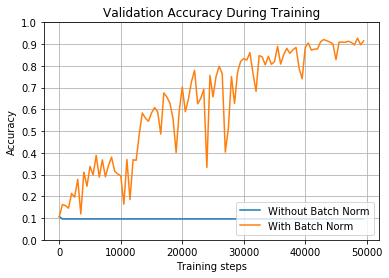

CPU times: user 7min 33s, sys: 15.7 s, total: 7min 48s
Wall time: 8min


In [18]:
%%time
train_and_test(True, 2, tf.nn.relu)

我们已经看到ReLU不如Sigmoid有更高的学习率，这里我们使用的是一个非常高的比率。正如所料，如果没有批量规范化，网络根本无法学习。但通过批量标准化，最终达到90%的准确率。不过，请注意，它的准确性是如何在训练过程中疯狂反弹的——这是因为学习率实在太高了，所以这一切都奏效了，这是一点运气。

**下面使用一个Sigmoid激活函数创建两个网络，学习率为2，起始权重不好**

100%|██████████| 50000/50000 [03:00<00:00, 276.36it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.8831999897956848


100%|██████████| 50000/50000 [05:02<00:00, 165.43it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9584000110626221
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.871999979019165
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9596999883651733


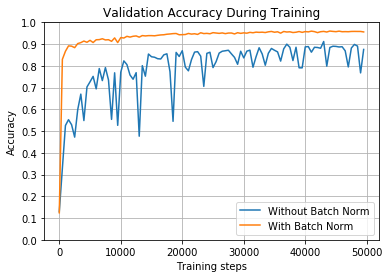

CPU times: user 7min 36s, sys: 15.7 s, total: 7min 52s
Wall time: 8min 4s


In [19]:
%%time
train_and_test(True, 2, tf.nn.sigmoid)

In this case, the network with batch normalization trained faster and reached a higher accuracy. Meanwhile, the high learning rate makes the network without normalization bounce around erratically and have trouble getting past 90%.

### Full Disclosure: Batch Normalization Doesn't Fix Everything

Batch normalization isn't magic and it doesn't work every time. Weights are still randomly initialized and batches are chosen at random during training, so you never know exactly how training will go. Even for these tests, where we use the same initial weights for both networks, we still get _different_ weights each time we run.

This section includes two examples that show runs when batch normalization did not help at all.

**下面使用ReLU激活函数创建两个网络，学习率为1，并且起始权重不正确**

100%|██████████| 50000/50000 [03:02<00:00, 274.36it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [05:13<00:00, 159.40it/s]


With Batch Norm: After training, final accuracy on validation set = 0.42559999227523804
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.421099990606308


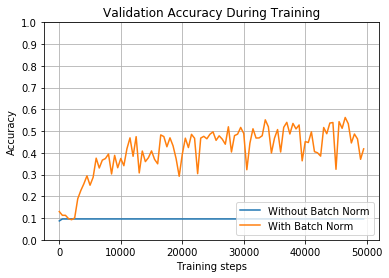

CPU times: user 7min 48s, sys: 16.2 s, total: 8min 5s
Wall time: 8min 17s


In [20]:
%%time
train_and_test(True, 1, tf.nn.relu)

当我们使用这些相同的参数 [earlier](#successful_example_lr_1), 我们看到，该网络的批量标准化达到92%的验证准确率。这一次我们使用了不同的起始权重，初始化时使用了与之前相同的标准差，网络根本无法学习。（请记住，如果网络总是猜测同一个值，那么准确率大约为10%。）             
             
**下面使用ReLU激活函数创建两个网络，学习率为2，起始权重不正确**

100%|██████████| 50000/50000 [03:12<00:00, 260.01it/s]


Without Batch Norm: After training, final accuracy on validation set = 0.0957999974489212


100%|██████████| 50000/50000 [05:14<00:00, 158.79it/s]


With Batch Norm: After training, final accuracy on validation set = 0.09860000014305115
---------------------------------------------------------------------------
Without Batch Norm: Accuracy on full test set = 0.09799999743700027
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.10100000351667404


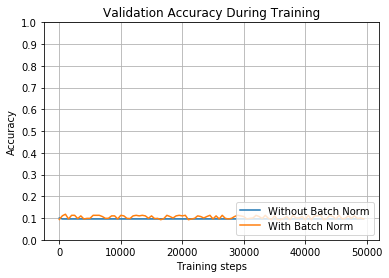

CPU times: user 7min 59s, sys: 16.8 s, total: 8min 15s
Wall time: 8min 28s


In [21]:
%%time
train_and_test(True, 2, tf.nn.relu)

When we trained with these parameters and batch normalization [earlier](#successful_example_lr_2), we reached 90% validation accuracy. However, this time the network _almost_ starts to make some progress in the beginning, but it quickly breaks down and stops learning. 

**Note:** Both of the above examples use *extremely* bad starting weights, along with learning rates that are too high. While we've shown batch normalization _can_ overcome bad values, we don't mean to encourage actually using them. The examples in this notebook are meant to show that batch normalization can help your networks train better. But these last two examples should remind you that you still want to try to use good network design choices and reasonable starting weights. It should also remind you that the results of each attempt to train a network are a bit random, even when using otherwise identical architectures.

# Batch Normalization: A Detailed Look<a id='implementation_2'></a>

The layer created by `tf.layers.batch_normalization` handles all the details of implementing batch normalization. Many students will be fine just using that and won't care about what's happening at the lower levels. However, some students may want to explore the details, so here is a short explanation of what's really happening, starting with the equations you're likely to come across if you ever read about batch normalization. 

In order to normalize the values, we first need to find the average value for the batch. If you look at the code, you can see that this is not the average value of the batch _inputs_, but the average value coming _out_ of any particular layer before we pass it through its non-linear activation function and then feed it as an input to the _next_ layer.

We represent the average as $\mu_B$, which is simply the sum of all of the values $x_i$ divided by the number of values, $m$ 

$$
\mu_B \leftarrow \frac{1}{m}\sum_{i=1}^m x_i
$$

We then need to calculate the variance, or mean squared deviation, represented as $\sigma_{B}^{2}$. If you aren't familiar with statistics, that simply means for each value $x_i$, we subtract the average value (calculated earlier as $\mu_B$), which gives us what's called the "deviation" for that value. We square the result to get the squared deviation. Sum up the results of doing that for each of the values, then divide by the number of values, again $m$, to get the average, or mean, squared deviation.

$$
\sigma_{B}^{2} \leftarrow \frac{1}{m}\sum_{i=1}^m (x_i - \mu_B)^2
$$

Once we have the mean and variance, we can use them to normalize the values with the following equation. For each value, it subtracts the mean and divides by the (almost) standard deviation. (You've probably heard of standard deviation many times, but if you have not studied statistics you might not know that the standard deviation is actually the square root of the mean squared deviation.)

$$
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2} + \epsilon}}
$$

Above, we said "(almost) standard deviation". That's because the real standard deviation for the batch is calculated by $\sqrt{\sigma_{B}^{2}}$, but the above formula adds the term epsilon, $\epsilon$, before taking the square root. The epsilon can be any small, positive constant - in our code we use the value `0.001`. It is there partially to make sure we don't try to divide by zero, but it also acts to increase the variance slightly for each batch. 

Why increase the variance? Statistically, this makes sense because even though we are normalizing one batch at a time, we are also trying to estimate the population distribution – the total training set, which itself an estimate of the larger population of inputs your network wants to handle. The variance of a population is higher than the variance for any sample taken from that population, so increasing the variance a little bit for each batch helps take that into account. 

At this point, we have a normalized value, represented as $\hat{x_i}$. But rather than use it directly, we multiply it by a gamma value, $\gamma$, and then add a beta value, $\beta$. Both $\gamma$ and $\beta$ are learnable parameters of the network and serve to scale and shift the normalized value, respectively. Because they are learnable just like weights, they give your network some extra knobs to tweak during training to help it learn the function it is trying to approximate.  

$$
y_i \leftarrow \gamma \hat{x_i} + \beta
$$

We now have the final batch-normalized output of our layer, which we would then pass to a non-linear activation function like sigmoid, tanh, ReLU, Leaky ReLU, etc. In the original batch normalization paper (linked in the beginning of this notebook), they mention that there might be cases when you'd want to perform the batch normalization _after_ the non-linearity instead of before, but it is difficult to find any uses like that in practice.

In `NeuralNet`'s implementation of `fully_connected`, all of this math is hidden inside the following line, where `linear_output` serves as the $x_i$ from the equations:
```python
batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
```
The next section shows you how to implement the math directly. 

### Batch normalization without the `tf.layers` package

Our implementation of batch normalization in `NeuralNet` uses the high-level abstraction [tf.layers.batch_normalization](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization), found in TensorFlow's [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) package.

However, if you would like to implement batch normalization at a lower level, the following code shows you how.
It uses [tf.nn.batch_normalization](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization) from TensorFlow's [neural net (nn)](https://www.tensorflow.org/api_docs/python/tf/nn) package.

**1)** You can replace the `fully_connected` function in the `NeuralNet` class with the below code and everything in `NeuralNet` will still work like it did before.

In [22]:
def fully_connected(self, layer_in, initial_weights, activation_fn=None):
    """
    Creates a standard, fully connected layer. Its number of inputs and outputs will be
    defined by the shape of `initial_weights`, and its starting weight values will be
    taken directly from that same parameter. If `self.use_batch_norm` is True, this
    layer will include batch normalization, otherwise it will not. 
        
    :param layer_in: Tensor
        The Tensor that feeds into this layer. It's either the input to the network or the output
        of a previous layer.
    :param initial_weights: NumPy array or Tensor
        Initial values for this layer's weights. The shape defines the number of nodes in the layer.
        e.g. Passing in 3 matrix of shape (784, 256) would create a layer with 784 inputs and 256 
        outputs. 
    :param activation_fn: Callable or None (default None)
        The non-linearity used for the output of the layer. If None, this layer will not include 
        batch normalization, regardless of the value of `self.use_batch_norm`. 
        e.g. Pass tf.nn.relu to use ReLU activations on your hidden layers.
    """
    if self.use_batch_norm and activation_fn:
        # Batch normalization uses weights as usual, but does NOT add a bias term. This is because 
        # its calculations include gamma and beta variables that make the bias term unnecessary.
        weights = tf.Variable(initial_weights)
        linear_output = tf.matmul(layer_in, weights)

        num_out_nodes = initial_weights.shape[-1]

        # Batch normalization adds additional trainable variables: 
        # gamma (for scaling) and beta (for shifting).
        gamma = tf.Variable(tf.ones([num_out_nodes]))
        beta = tf.Variable(tf.zeros([num_out_nodes]))

        # These variables will store the mean and variance for this layer over the entire training set,
        # which we assume represents the general population distribution.
        # By setting `trainable=False`, we tell TensorFlow not to modify these variables during
        # back propagation. Instead, we will assign values to these variables ourselves. 
        pop_mean = tf.Variable(tf.zeros([num_out_nodes]), trainable=False)
        pop_variance = tf.Variable(tf.ones([num_out_nodes]), trainable=False)

        # Batch normalization requires a small constant epsilon, used to ensure we don't divide by zero.
        # This is the default value TensorFlow uses.
        epsilon = 1e-3

        def batch_norm_training():
            # Calculate the mean and variance for the data coming out of this layer's linear-combination step.
            # The [0] defines an array of axes to calculate over.
            batch_mean, batch_variance = tf.nn.moments(linear_output, [0])

            # Calculate a moving average of the training data's mean and variance while training.
            # These will be used during inference.
            # Decay should be some number less than 1. tf.layers.batch_normalization uses the parameter
            # "momentum" to accomplish this and defaults it to 0.99
            decay = 0.99
            train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
            train_variance = tf.assign(pop_variance, pop_variance * decay + batch_variance * (1 - decay))

            # The 'tf.control_dependencies' context tells TensorFlow it must calculate 'train_mean' 
            # and 'train_variance' before it calculates the 'tf.nn.batch_normalization' layer.
            # This is necessary because the those two operations are not actually in the graph
            # connecting the linear_output and batch_normalization layers, 
            # so TensorFlow would otherwise just skip them.
            with tf.control_dependencies([train_mean, train_variance]):
                return tf.nn.batch_normalization(linear_output, batch_mean, batch_variance, beta, gamma, epsilon)
 
        def batch_norm_inference():
            # During inference, use the our estimated population mean and variance to normalize the layer
            return tf.nn.batch_normalization(linear_output, pop_mean, pop_variance, beta, gamma, epsilon)

        # Use `tf.cond` as a sort of if-check. When self.is_training is True, TensorFlow will execute 
        # the operation returned from `batch_norm_training`; otherwise it will execute the graph
        # operation returned from `batch_norm_inference`.
        batch_normalized_output = tf.cond(self.is_training, batch_norm_training, batch_norm_inference)
            
        # Pass the batch-normalized layer output through the activation function.
        # The literature states there may be cases where you want to perform the batch normalization *after*
        # the activation function, but it is difficult to find any uses of that in practice.
        return activation_fn(batch_normalized_output)
    else:
        # When not using batch normalization, create a standard layer that multiplies
        # the inputs and weights, adds a bias, and optionally passes the result 
        # through an activation function.  
        weights = tf.Variable(initial_weights)
        biases = tf.Variable(tf.zeros([initial_weights.shape[-1]]))
        linear_output = tf.add(tf.matmul(layer_in, weights), biases)
        return linear_output if not activation_fn else activation_fn(linear_output)


This version of `fully_connected` is much longer than the original, but once again has extensive comments to help you understand it. Here are some important points:

1. It explicitly creates variables to store gamma, beta, and the population mean and variance. These were all handled for us in the previous version of the function.
2. It initializes gamma to one and beta to zero, so they start out having no effect in this calculation: $y_i \leftarrow \gamma \hat{x_i} + \beta$. However, during training the network learns the best values for these variables using back propagation, just like networks normally do with weights.
3. Unlike gamma and beta, the variables for population mean and variance are marked as untrainable. That tells TensorFlow not to modify them during back propagation. Instead, the lines that call `tf.assign` are used to update these variables directly.
4. TensorFlow won't automatically run the `tf.assign` operations during training because it only evaluates operations that are required based on the connections it finds in the graph. To get around that, we add this line: `with tf.control_dependencies([train_mean, train_variance]):` before we run the normalization operation. This tells TensorFlow it needs to run those operations before running anything inside the `with` block. 
5. The actual normalization math is still mostly hidden from us, this time using [`tf.nn.batch_normalization`](https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization).
5. `tf.nn.batch_normalization` does not have a `training` parameter like `tf.layers.batch_normalization` did. However, we still need to handle training and inference differently, so we run different code in each case using the [`tf.cond`](https://www.tensorflow.org/api_docs/python/tf/cond) operation.
6. We use the [`tf.nn.moments`](https://www.tensorflow.org/api_docs/python/tf/nn/moments) function to calculate the batch mean and variance.

**2)** The current version of the `train` function in `NeuralNet` will work fine with this new version of `fully_connected`. However, it uses these lines to ensure population statistics are updated when using batch normalization: 
```python
if self.use_batch_norm:
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
else:
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
```
Our new version of `fully_connected` handles updating the population statistics directly. That means you can also simplify your code by replacing the above `if`/`else` condition with just this line:
```python
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
```

**3)** And just in case you want to implement every detail from scratch, you can replace this line in `batch_norm_training`:

```python
return tf.nn.batch_normalization(linear_output, batch_mean, batch_variance, beta, gamma, epsilon)
```
with these lines:
```python
normalized_linear_output = (linear_output - batch_mean) / tf.sqrt(batch_variance + epsilon)
return gamma * normalized_linear_output + beta
```
And replace this line in `batch_norm_inference`:
```python
return tf.nn.batch_normalization(linear_output, pop_mean, pop_variance, beta, gamma, epsilon)
```
with these lines:
```python
normalized_linear_output = (linear_output - pop_mean) / tf.sqrt(pop_variance + epsilon)
return gamma * normalized_linear_output + beta
```

As you can see in each of the above substitutions, the two lines of replacement code simply implement the following two equations directly. The first line calculates the following equation, with `linear_output` representing $x_i$ and `normalized_linear_output` representing $\hat{x_i}$: 

$$
\hat{x_i} \leftarrow \frac{x_i - \mu_B}{\sqrt{\sigma_{B}^{2} + \epsilon}}
$$

And the second line is a direct translation of the following equation:

$$
y_i \leftarrow \gamma \hat{x_i} + \beta
$$

We still use the `tf.nn.moments` operation to implement the other two equations from earlier – the ones that calculate the batch mean and variance used in the normalization step. If you really wanted to do everything from scratch, you could replace that line, too, but we'll leave that to you.  

## Why the difference between training and inference?

In the original function that uses `tf.layers.batch_normalization`, we tell the layer whether or not the network is training by passing a value for its `training` parameter, like so:
```python
batch_normalized_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
```
And that forces us to provide a value for `self.is_training` in our `feed_dict`, like we do in this example from `NeuralNet`'s `train` function:
```python
session.run(train_step, feed_dict={self.input_layer: batch_xs, 
                                   labels: batch_ys, 
                                   self.is_training: True})
```
If you looked at the [low level implementation](#low_level_code), you probably noticed that, just like with `tf.layers.batch_normalization`, we need to do slightly different things during training and inference. But why is that?

First, let's look at what happens when we don't. The following function is similar to `train_and_test` from earlier, but this time we are only testing one network and instead of plotting its accuracy, we perform 200 predictions on test inputs, 1 input at at time. We can use the `test_training_accuracy` parameter to test the network in training or inference modes (the equivalent of passing `True` or `False` to the `feed_dict` for `is_training`).

In [23]:
def batch_norm_test(test_training_accuracy):
    """
    :param test_training_accuracy: bool
        If True, perform inference with batch normalization using batch mean and variance;
        if False, perform inference with batch normalization using estimated population mean and variance.
    """

    weights = [np.random.normal(size=(784,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,100), scale=0.05).astype(np.float32),
               np.random.normal(size=(100,10), scale=0.05).astype(np.float32)
              ]

    tf.reset_default_graph()

    # Train the model
    bn = NeuralNet(weights, tf.nn.relu, True)
 
    # First train the network
    with tf.Session() as sess:
        tf.global_variables_initializer().run()

        bn.train(sess, 0.01, 2000, 2000)

        bn.test(sess, test_training_accuracy=test_training_accuracy, include_individual_predictions=True)

在下面的单元格中，我们通过了`test_training_accurity`的`True`，它执行的批处理规范化与我们通常在**训练期间执行的**相同。

In [24]:
%%time
batch_norm_test(True)

100%|██████████| 2000/2000 [00:11<00:00, 177.84it/s]


With Batch Norm: After training, final accuracy on validation set = 0.9549999833106995
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9524000287055969
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instr

如你所见，网络每次都猜到同样的值！但为什么呢？因为在训练过程中，一个具有批标准化的网络会根据该批**的均值和方差**来调整每一层的值。我们用于这些预测的“批”每次只有一个输入，因此它们的值是平均值，它们的方差总是0。这意味着网络会将任何层的值规范化为零。（回顾之前的方程式，看看为什么一个等于平均值的值总是标准化为零。）因此，对于我们给网络的每个输入，我们得到的结果都是相同的，因为它是网络在每一层将其学习权重应用于零时产生的值。    
         
**注意：**如果重新运行该单元格，可能会得到与我们显示的不同的值。这是因为网络每次学习的具体权重都不同。但不管它的价值是什么，对所有200个预测来说都应该是一样的。        
        
为了解决这个问题，网络不仅仅是规范化每一层的批处理。它还保持对整个人口的均值和方差的估计。因此，当我们进行推理时，它不是让它使用自己的均值和方差“规范化”所有值，而是使用它在训练时计算的总体均值和方差的估计值。     
              
因此在下面的例子中，我们通过了“test_training_accurity”的“False”，它告诉网络它想用它在训练期间计算的人口统计数据进行推断。

In [25]:
%%time
batch_norm_test(False)

100%|██████████| 2000/2000 [00:13<00:00, 153.18it/s]


With Batch Norm: After training, final accuracy on validation set = 0.954800009727478
---------------------------------------------------------------------------
With Batch Norm: Accuracy on full test set = 0.9534000158309937
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instructions for updating:
Use `argmax` instead
Instru

As you can see, now that we're using the estimated population mean and variance, we get a 97% accuracy. That means it guessed correctly on 194 of the 200 samples – not too bad for something that trained in under 4 seconds. :)

# Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizaing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

When using `tf.layers.batch_normalization`, be sure to pay attention to the order of your convolutionlal dimensions.
Specifically, you may want to set a different value for the `axis` parameter if your layers have their channels first instead of last. 

In our low-level implementations, we used the following line to calculate the batch mean and variance:
```python
batch_mean, batch_variance = tf.nn.moments(linear_output, [0])
```
If we were dealing with a convolutional layer, we would calculate the mean and variance with a line like this instead:
```python
batch_mean, batch_variance = tf.nn.moments(conv_layer, [0,1,2], keep_dims=False)
```
The second parameter, `[0,1,2]`, tells TensorFlow to calculate the batch mean and variance over each feature map. (The three axes are the batch, height, and width.) And setting `keep_dims` to `False` tells `tf.nn.moments` not to return values with the same size as the inputs. Specifically, it ensures we get one mean/variance pair per feature map.

### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone extended `tf.nn.rnn_cell.RNNCell` to include batch normalization in [this GitHub repo](https://gist.github.com/spitis/27ab7d2a30bbaf5ef431b4a02194ac60).

$$\;$$